# Random Forest classifier evaluation
This notebook can be used to evaluate performance of different variants of a Random Forest classifier (or any other sklearn classifier). In order to run run it you must have:
- trained some new classifiers that you want to evaluate
- run the paycheck cross-validation on all of those
- stored the results of all cross-validations in one directory (specified below)

In terms of code execution, you should have run:
- `paycheck_generate_folds` to prepare the train/test datasets used in the next step (for a _k_ number of folds)
- `paycheck_cv_classifier` to cross-validate the classifiers _k_-times (exact specs for every classifier can be passed as an argument to that method)

Following the cross-validation step, you should end up with a directory structure similar to this:
```
project_dir/
  |
  +--sample-type-1/
  |   |
  |   +--results/
  |   |   |
  |   |   +--abundance/
  |   |   +--expected/
  |   |   +--relative_frequencies/
  |   |   +--RandomForest/
  |   |       |
  |   |       +--class-weights-1/
  |   |       +--class-weights-2/
  |   |       +--class-weights-3/
  |   +--tmp/
  |       |
  |       +--fold-0/
  |       +--fold-1/
  |       +--fold-k/
  +--sample-type-2/
```
where `sample-type-1/2` is the type of the sample on which you want to perform the analysis (e.g. sediment-non-saline) and `class-weights-1/2/3` indicates your specifc classifiers that should be evaluated. You should indicate the correct `project_dir` and `sample_type` in the cells below. Paths to `class-weights` should be discovered automatically, given the directory structure above (that means you'll probably need to move some files around).

## Imports and required function definitions

In [11]:
import os

from joblib import Parallel, delayed
import qiime2
import biom
import numpy as np
import pandas as pd
import seaborn as sns
from qiime2.plugins import feature_table
from qiime2.plugins import taxa
import matplotlib.pyplot as plt

from glob import glob
import json

from q2_quality_control._evaluate_taxonomy import _evaluate_taxonomy
from q2_quality_control._utilities import (
    _evaluate_composition, _compute_per_level_accuracy, _match_samples_by_index, _drop_nans_zeros)

%matplotlib inline

In [12]:
def _calc_prf(exp_taxa, obs_taxa, table):
    # calculate weighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=table,
        sample_id=None)
    prf['method'] = 'weighted'
    prf_results = prf

    # calculate unweighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=None,
        sample_id=None)
    prf['method'] = 'unweighted'
    prf_results = pd.concat([prf_results, prf])
    
    return prf_results


def _collapse_frequency_table_to_relative_frequency(table, taxonomy, level=7):
    for level in range(level, 0, -1):
        # to cater for truncated classifications
        try:
            table_l7 = taxa.methods.collapse(table=table, level=level, taxonomy=taxonomy)
            break
        except ValueError:
            pass
    rel_freq = feature_table.methods.relative_frequency(table_l7.collapsed_table)
    obs_table = rel_freq.relative_frequency_table.view(pd.DataFrame)
    return obs_table


def _eval_comp_basic(exp, obs, depth=7):
    exp, obs = _match_samples_by_index(exp, obs)

    # DROP NANS/ZERO ABUNDANCE FEATURES
    obs = _drop_nans_zeros(obs)
    exp = _drop_nans_zeros(exp)

    for depth in range(depth, 0, -1):
        # TAR/TDR for obs vs. exp at each level
        try:
            results, vectors = _compute_per_level_accuracy(exp, obs, metadata=None, depth=depth)
            break
        except ValueError:
            pass
    return results


def _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp):
    table_fp = os.path.join(frequencies_dir, fn)
    table = qiime2.Artifact.load(table_fp)
    rel_freq = feature_table.methods.relative_frequency(table)
    rel_freq.relative_frequency_table.save(rel_freq_fp)
    table = rel_freq.relative_frequency_table.view(biom.Table)
    return table


def _eval_for_class_weights(
    cw, type_dir, expected_dir, fns, frequencies_dir, relative_frequencies_dir):
    prf_results = pd.DataFrame()
    eval_results = pd.DataFrame()
    if cw == sample_type:
        return prf_results, eval_results

    cw_dir = os.path.join(type_dir, cw)
    # evaluate taxonomy
    for fn in fns:
        if fn in ['log', 'log_missed']:
            continue
        sample, _ = os.path.splitext(fn)

        # convert table to relative frequencies
        rel_freq_fp = os.path.join(relative_frequencies_dir, fn)
        if not os.path.exists(rel_freq_fp):
            table = _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp)
        else:
            try:
                table = qiime2.Artifact.load(rel_freq_fp).view(biom.Table)
            except Exception as e:
                print(
                    f"An exception has occurred: {e}. Will try to recreate artifact."
                )
                table = _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp)

        # load data
        exp_taxa_fp = os.path.join(expected_dir, fn)
        exp_taxa = qiime2.Artifact.load(exp_taxa_fp).view(pd.DataFrame)
        obs_taxa_fp = os.path.join(cw_dir, fn)
        obs_taxa = qiime2.Artifact.load(obs_taxa_fp).view(pd.DataFrame)

        results = _calc_prf(exp_taxa, obs_taxa, table)
        results['class weights'] = cw
        results['sample type'] = sample_type
        results['sample'] = sample

        prf_results = pd.concat([prf_results, results])

        # evaluate composition
        table_fp = os.path.join(frequencies_dir, fn)
        table = qiime2.Artifact.load(table_fp)
        exp_table = _collapse_frequency_table_to_relative_frequency(
            table, qiime2.Artifact.load(exp_taxa_fp))
        obs_table = _collapse_frequency_table_to_relative_frequency(
            table, qiime2.Artifact.load(obs_taxa_fp))

        results = _eval_comp_basic(exp_table, obs_table)
        results['class weights'] = cw
        results['sample type'] = sample_type
        results['sample'] = sample

        eval_results = pd.concat([eval_results, results])

    return prf_results, eval_results

def _check_sample_type(fns, df, class_weights, sample_type, is_prf=False):
    if len(df) == 0:
        return fns
    type_and_weight = df[df['sample type'] == sample_type]['sample']
    for_eval = []
    for fn in fns:
        levels = sum(type_and_weight == fn[:-4])
        m = 2 if is_prf else 1
        assert levels == 0 or levels == 7*m*(len(class_weights) - 1), \
            'got partial record for ' + fn
        if levels == 0:
            for_eval.append(fn)
    return for_eval

def _get_params_from_model(model_descriptor):
    # RandomForest/9-16-1000-sqrt-0.8
    model_name = model_descriptor.split("/")[0]
    model_params = model_descriptor.split("/")[1]
    
    model_id, confidence, depth, features, estimators = None, None, None, None, None
    param_split = model_params.split('-')
    if len(param_split) == 2:
        model_id = param_split[0]
        confidence = float(param_split[1])
    elif len(param_split) == 5:
        model_id = f"{model_name}{param_split[0]}"
        depth = int(param_split[1]) if param_split[1] != "none" else "none"
        estimators = int(param_split[2])
        features = param_split[3]
        confidence = float(param_split[4])
    return model_id, confidence, depth, features, estimators

## Data sources and sample types
In order to run the analyses below, update the path to where your data is located (`project_dir`). Also, indicate which sample types you want to use in the analysis (corresponding directories need to exist within your project directory). Class weights paths will be discovered automatically - you should see them below.

Most of the analyses/figures presented here refer to only one sample type though, so only the first element of `sample_types` is usually taken into account.

In [13]:
project_dir = os.path.expandvars('/Users/mziemski/feature_classifier_paper/data/eval_rf/')
sample_types = ['sediment-non-saline']

In [14]:
class_weights = []
for path in glob(os.path.join(project_dir, sample_types[0], 'results', 'RandomForest', '*')):
    class_weights.append('/'.join(path.split('/')[-2:]))

In [15]:
class_weights

['RandomForest/9-16-1000-sqrt-0.8',
 'RandomForest/15-64-100-sqrt-0.8',
 'RandomForest/12-16-1000-none-0.8',
 'RandomForest/1-16-100-sqrt-0.6',
 'RandomForest/13-64-100-sqrt-0.6',
 'RandomForest/8-16-1000-sqrt-0.7',
 'RandomForest/7-16-1000-sqrt-0.6',
 'RandomForest/c4-none-10-none-0.3',
 'RandomForest/6-16-100-none-0.8',
 'RandomForest/14-64-100-sqrt-0.7',
 'RandomForest/30-none-100-none-0.8',
 'RandomForest/3-16-100-sqrt-0.8',
 'RandomForest/29-none-100-none-0.7',
 'RandomForest/c5-none-100-none-0.5',
 'RandomForest/nb-0.7',
 'RandomForest/16-64-100-none-0.6',
 'RandomForest/c4-none-100-none-0.4',
 'RandomForest/nb-0.8',
 'RandomForest/c4-none-100-none-0.3',
 'RandomForest/4-16-100-none-0.6',
 'RandomForest/10-16-1000-none-0.6',
 'RandomForest/28-none-100-none-0.6',
 'RandomForest/nb-0.6',
 'RandomForest/5-16-100-none-0.7',
 'RandomForest/18-64-100-none-0.8',
 'RandomForest/17-64-100-none-0.7',
 'RandomForest/11-16-1000-none-0.7',
 'RandomForest/2-16-100-sqrt-0.7']

## Run the evaluation

#### Evaluate cross-validation results or read the evaluation from file.

In [16]:
if os.path.exists(os.path.join(project_dir, 'eval_comp_results.tsv')):
    eval_comp_results = pd.read_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')
else:
    eval_comp_results = pd.DataFrame()
if os.path.exists(os.path.join(project_dir, 'eval_taxa_prf.tsv')):
    prf_results = pd.read_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')
else:
    prf_results = pd.DataFrame()

if not eval_comp_results.shape[0] > 0 and not prf_results.shape[0] > 0:
    for sample_type in sample_types:
        type_results = pd.DataFrame()
        type_dir = os.path.join(project_dir, sample_type, 'results')
        expected_dir = os.path.join(type_dir, 'expected')
        fns = os.listdir(expected_dir)
        frequencies_dir = os.path.join(type_dir, 'abundance')
        relative_frequencies_dir = os.path.join(type_dir, 'relative_frequencies')
        if not os.path.exists(relative_frequencies_dir):
            os.makedirs(relative_frequencies_dir)

        results = Parallel(n_jobs=6, verbose=50, batch_size=1)(
            delayed(_eval_for_class_weights)(
                cw, type_dir, expected_dir, fns, 
                frequencies_dir, relative_frequencies_dir) 
            for cw in class_weights)

        prf_list, eval_list = zip(*results)
        prf_results = pd.concat([prf_results] + list(prf_list))
        eval_comp_results = pd.concat([eval_comp_results] + list(eval_list))
        
        eval_comp_results.to_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')
        prf_results.to_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')
else:
    print("Evaluation results were loaded from a file.")

Evaluation results were loaded from a file.


In [17]:
print("Evaluation results shape:", eval_comp_results.shape, "and columns:", eval_comp_results.columns)
print("PRF results shape:", prf_results.shape)

Evaluation results shape: (4141561, 16) and columns: Index(['sample', 'level', 'Observed Taxa', 'Observed / Expected Taxa', 'TAR',
       'TDR', 'Slope', 'Intercept', 'r-value', 'P value', 'Std Err',
       'Bray-Curtis', 'Jaccard', 'r-squared', 'class weights', 'sample type'],
      dtype='object')
PRF results shape: (8299004, 8)


In [18]:
prf_results["class weights"].unique()

array(['RandomForest/9-16-1000-sqrt-0.8',
       'RandomForest/15-64-100-sqrt-0.8',
       'RandomForest/12-16-1000-none-0.8',
       'RandomForest/1-16-100-sqrt-0.6',
       'RandomForest/13-64-100-sqrt-0.6',
       'RandomForest/8-16-1000-sqrt-0.7',
       'RandomForest/7-16-1000-sqrt-0.6',
       'RandomForest/6-16-100-none-0.8',
       'RandomForest/14-64-100-sqrt-0.7',
       'RandomForest/30-none-100-none-0.8',
       'RandomForest/3-16-100-sqrt-0.8',
       'RandomForest/29-none-100-none-0.7', 'RandomForest/nb-0.7',
       'RandomForest/16-64-100-none-0.6', 'RandomForest/nb-0.8',
       'RandomForest/4-16-100-none-0.6',
       'RandomForest/10-16-1000-none-0.6',
       'RandomForest/28-none-100-none-0.6', 'RandomForest/nb-0.6',
       'RandomForest/5-16-100-none-0.7',
       'RandomForest/18-64-100-none-0.8',
       'RandomForest/17-64-100-none-0.7',
       'RandomForest/11-16-1000-none-0.7',
       'RandomForest/2-16-100-sqrt-0.7',
       'RandomForest/c4-none-10-none-0.3',
   

In [19]:
# clean up some stray columns (all starting with "Unnamed" - probably DF index that was repeatedly saved to file)
cols_to_keep = [col for col in eval_comp_results.columns if not col.startswith('Unnamed')]
eval_comp_results_clean = eval_comp_results[cols_to_keep]

cols_to_keep = [col for col in prf_results.columns if not col.startswith('Unnamed')]
prf_results_clean = prf_results[cols_to_keep]
prf_results_clean["model name"], prf_results_clean["confidence"], prf_results_clean["max_depth"], prf_results_clean["n_features"], prf_results_clean["n_estimators"] = zip(
    *prf_results_clean["class weights"].apply(_get_params_from_model))

# save as a backup
eval_comp_results_clean.to_csv(os.path.join(project_dir, 'eval_comp_results_cleaned.tsv'), sep='\t')
prf_results_clean.to_csv(os.path.join(project_dir, 'eval_taxa_prf_cleaned.tsv'), sep='\t')

print(eval_comp_results_clean.shape, prf_results_clean.shape)

(4141561, 16) (8299004, 13)


In [20]:
prf_results_clean.head(2)

,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,max_depth,n_features,n_estimators
0,1,1.0,1.000000,1.000000,weighted,RandomForest/9-16-1000-sqrt-0.8,sediment-non-saline,10184.10030521.61428,RandomForest9,0.8,16,sqrt,1000
1,2,1.0,0.899633,0.947165,weighted,RandomForest/9-16-1000-sqrt-0.8,sediment-non-saline,10184.10030521.61428,RandomForest9,0.8,16,sqrt,1000


#### Read in information about the cross-validation folds.

In [21]:
folds_loc = os.path.join(project_dir, sample_types[0], "tmp")
test_seqs = {}
for fold in glob(os.path.join(folds_loc, "*")):
    fold_base = fold.split("/")[-1]
    if fold_base.startswith("fold"):
        with open(os.path.join(fold, "sample_test.json")) as json_file:
            seq_ids = json.load(json_file)
            test_seqs[fold_base] = seq_ids
test_seqs_map = {}
for fold, seq_ids in test_seqs.items():
    for seq_id in seq_ids:
        if seq_id not in test_seqs_map.keys():
            test_seqs_map[seq_id] = fold.split("-")[-1]
        else:
            print(f"Sequence id {seq_id} already exists! - skipping")

test_seqs_map_df = pd.DataFrame(test_seqs_map.items(), columns=["id", "fold"])
test_seqs_map_df.head(4)

,id,fold
0,11757.G445224461.58900,2
1,11757.G440205035.58900,2
2,11757.G445302613.58900,2
3,11757.G441303167.58900,2


## Visualise classification accuracy 
Run the cells below to generate plots showing various accuracy metrics of different samples and class weights (your classifiers) at all taxonomy levels. Only results of `weighted` analysis will be taken into account and used for plotting. All plots will be generated only for the `species` level (level 7).

In [22]:
level7 = prf_results_clean[prf_results_clean['level'] == 7]
level7_weighted = level7[level7['method'] == 'weighted']

In [23]:
print(level7_weighted.shape)
level7_weighted.head(2)

(592786, 13)


,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,max_depth,n_features,n_estimators
6,7,0.985453,0.373797,0.542004,weighted,RandomForest/9-16-1000-sqrt-0.8,sediment-non-saline,10184.10030521.61428,RandomForest9,0.8,16,sqrt,1000
20,7,0.964433,0.207215,0.341135,weighted,RandomForest/9-16-1000-sqrt-0.8,sediment-non-saline,11757.G440205218.58900,RandomForest9,0.8,16,sqrt,1000


Add information about folds.

In [24]:
level7_weighted_folds = pd.merge(left=level7_weighted, right=test_seqs_map_df, left_on="sample", right_on="id")

if level7_weighted_folds.shape[0] != level7_weighted.shape[0]:
    print("Some samples were lost during merging fold information into original df.")
else:
    print("Merge successful.")

Merge successful.


Fill NB parameters' columns to avoid NaNs. 

In [25]:
level7_weighted_folds.loc[level7_weighted_folds["model name"] == "nb", ["max_depth", "n_estimators", "n_features"]] = "NB"

Double check that there are no NaN values in parameter columns.

In [26]:
for param in ["n_estimators", "n_features", "max_depth"]:
    print(level7_weighted_folds[param].unique())

[1000 100 'NB' 10]
['sqrt' 'none' 'NB']
[16 64 'none' 'NB']


### Metrics per taxonomic level

In [27]:
def boxplots_per_confidence(data, metric, conf_levels, param, palette, x_order, y_lims, y_ticks_major, y_ticks_minor, x_label, save_loc=None):
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 3)
        fig.set_size_inches(16, 5)

        for j, conf in enumerate(conf_levels):
            data_before_group = data[data["confidence"] == conf]

            grouped_level7 = data_before_group.groupby(['model name', 'level', 'confidence', 'fold', param])
            axis_data = grouped_level7.mean().reset_index()

            g = sns.boxplot(
                x=param, y=metric, data=axis_data, ax=axes[j], palette=palette, order=x_order)
            g.set_ylim(y_lims)
            g.yaxis.set_ticks(np.arange(y_ticks_major[0], y_ticks_major[1], 0.1))
            if y_ticks_minor:
                minor_locator = AutoMinorLocator(2)
                g.yaxis.set_minor_locator(minor_locator)
                g.tick_params(which='minor', length=4)
                g.grid(True, which='minor', axis='y')

            # set a common x-axis label
            if j == 1:
                g.set_xlabel(x_label, fontsize=15)
            else:
                g.set_xlabel("")

            # remove x-ticks from most of the plots and set y-axis labels' size
            if j > 0:
                g.set_yticklabels([])
                g.set_ylabel("")
            else:
                g.tick_params(left='on', which='both')
                g.yaxis.label.set_size(15)
                for tick in g.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14)
            for tick in g.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14)

            # add confidence labels to the top of the grid
            g.text(1., .935, f"Confidence = {conf}", verticalalignment ='center', horizontalalignment ='center', fontsize=14)
        if save_loc:
            fig.savefig(save_loc, dpi=300)

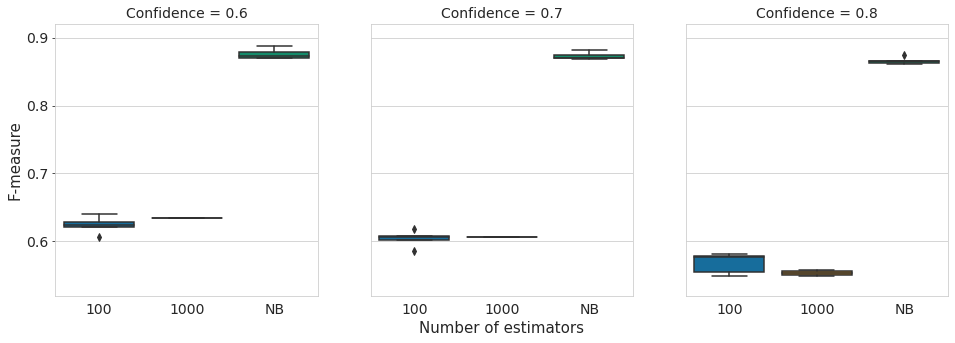

In [28]:
metric = "F-measure"
params = ["n_estimators", "n_features", "max_depth"]
y_lims = [0.52, 0.92]
y_ticks_major = [0.6, 1.0]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold"]
conf_levels = [0.6, 0.7, 0.8]
palette = "colorblind"
param = "n_estimators"
x_label = "Number of estimators"
order = [100, 1000, "NB"]
# fig_save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-{param}.eps")
fig_save_loc = None

data_slice = level7_weighted_folds[[metric] + params + other_columns]
data = data_slice[(data_slice["max_depth"].isin([16, "NB"])) & (data_slice["n_features"].isin(["none","NB"]))]

boxplots_per_confidence(data, metric, conf_levels, param, palette, order, y_lims, y_ticks_major, y_ticks_minor, x_label, fig_save_loc)

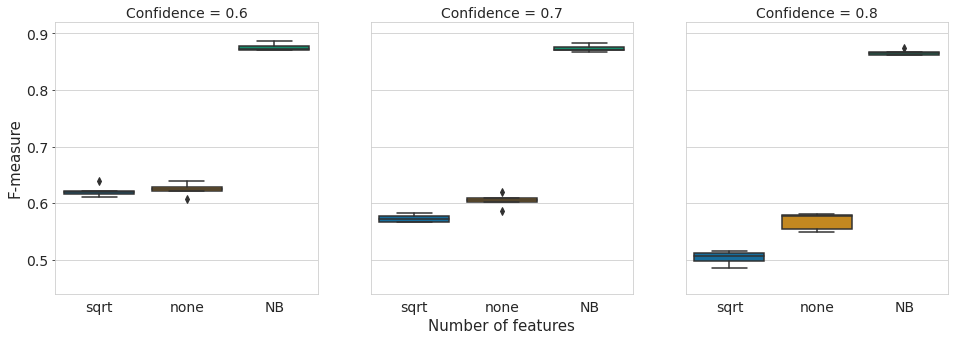

In [29]:
metric = "F-measure"
params = ["n_estimators", "n_features", "max_depth"]
y_lims = [0.44, 0.92]
y_ticks_major = [0.5, 1.0]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold"]
conf_levels = [0.6, 0.7, 0.8]
palette = "colorblind"
param = "n_features"
x_label = "Number of features"
order = ["sqrt", "none", "NB"]
# fig_save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-{param}.svg")
fig_save_loc = None

data_slice = level7_weighted_folds[[metric] + params + other_columns]
data = data_slice[(data_slice["max_depth"].isin([16, "NB"])) & (data_slice["n_estimators"].isin([100,"NB"]))]

boxplots_per_confidence(data, metric, conf_levels, param, palette, order, y_lims, y_ticks_major, y_ticks_minor, x_label, fig_save_loc)

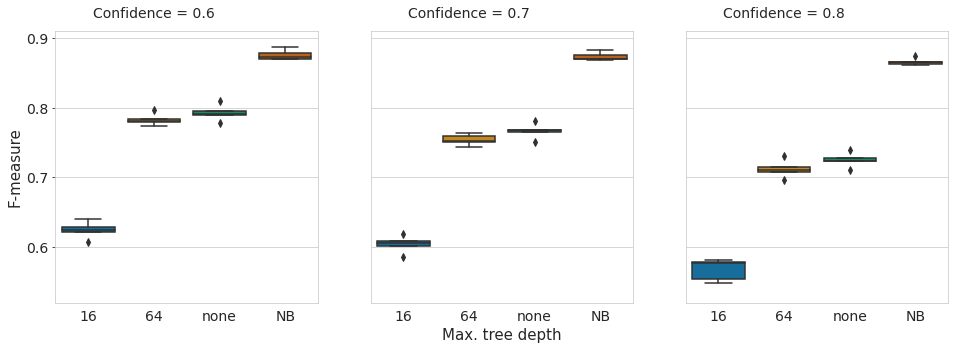

In [30]:
metric = "F-measure"
params = ["n_estimators", "n_features", "max_depth"]
y_lims = [0.52, 0.91]
y_ticks_major = [0.6, 1.0]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold"]
conf_levels = [0.6, 0.7, 0.8]
palette = "colorblind"
param = "max_depth"
x_label = "Max. tree depth"
order = [16, 64, "none", "NB"]
# fig_save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-{param}.svg")
fig_save_loc = None

data_slice = level7_weighted_folds[[metric] + params + other_columns]
data = data_slice[(data_slice["n_estimators"].isin([100, "NB"])) & (data_slice["n_features"].isin(["none", "NB"]))]

boxplots_per_confidence(data, metric, conf_levels, param, palette, order, y_lims, y_ticks_major, y_ticks_minor, x_label, fig_save_loc)

Generate one horizontal plot with selected models.

In [71]:
from matplotlib.ticker import AutoMinorLocator

def plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, save_loc=None):
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(24, 5)

        # calculate mean metric for each fold by grouping by model
        # reset index to unstack all the levels from the multi-level index for easy plotting
        grouped_level7 = data.groupby(['model name', 'level', 'confidence', 'fold', "class weights"] + params)
        axis_data = grouped_level7.mean().reset_index()
        axis_data.sort_values(["confidence"] + params, ascending=True, inplace=True)

        # sort by confidence to plot in confidence groups
        all_models = axis_data["class weights"].unique()
        all_models_sorted = sorted(all_models, key=lambda x: x.split("-")[-1])

        # set proper colours (for first 3 boxes + 3 groups of 6 boxes)
        base_colors = sns.color_palette(palette, axis_data[params].drop_duplicates(inplace=False).shape[0] + 3)
        color_palette = base_colors[-3:] + base_colors[:-3] * 3
        g = sns.boxplot(x="class weights", y=metric, data=axis_data, ax=axes, palette=color_palette, order=all_models_sorted)

        # set custom y ticks
        g.yaxis.set_ticks(np.arange(y_ticks_major[0], y_ticks_major[1], 0.1))
        if y_ticks_minor:
            minor_locator = AutoMinorLocator(2)
            g.yaxis.set_minor_locator(minor_locator)
            g.tick_params(which='minor', length=4)
            g.grid(True, which='minor', axis='y')

        # set some font sizes
        g.yaxis.label.set_size(15)
        for tick in g.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        for tick in g.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)
            tick.label.set_rotation(90)

        # relabel x-axis tick for easier identification
        new_x_tick_labels = ["-".join(tick._text.split("/")[-1].split("-")[1:]) for tick in g.get_xticklabels()]
        g.set_xticklabels(new_x_tick_labels)

        if save_loc:
            fig.savefig(save_loc, dpi=300)
            
        plt.show()
        
        return axis_data

def calculate_aggregate_metrics(axis_data, metric, grouping_column):
    axis_data_grouped = axis_data[[metric, grouping_column]].groupby(grouping_column)
    metric_table = pd.concat([axis_data_grouped.mean(), axis_data_grouped.sem()], axis=1)
    metric_table.columns = [f"Avg {metric}", "SEM"]
    return metric_table

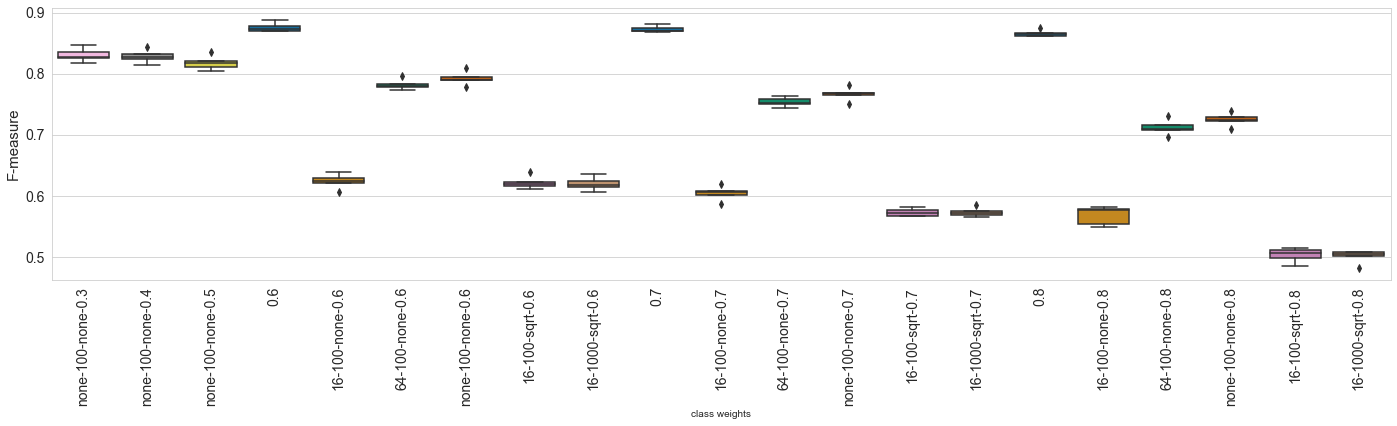

,Avg F-measure,SEM
class weights,,
RandomForest/1-16-100-sqrt-0.6,0.621907,0.004823
RandomForest/16-64-100-none-0.6,0.782323,0.003754
RandomForest/17-64-100-none-0.7,0.753864,0.003544
RandomForest/18-64-100-none-0.8,0.711944,0.005542
RandomForest/2-16-100-sqrt-0.7,0.573106,0.003028
RandomForest/28-none-100-none-0.6,0.792389,0.005149
RandomForest/29-none-100-none-0.7,0.766562,0.004832
RandomForest/3-16-100-sqrt-0.8,0.503633,0.005300
RandomForest/30-none-100-none-0.8,0.725029,0.004739


In [72]:
metric = "F-measure"
params = ["n_features", "n_estimators", "max_depth"]
y_ticks_major = [0.5, 1.0]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold", "class weights"]
conf_levels = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-allmodels-updated-low-confs.svg")

data_slice = level7_weighted_folds[["F-measure", "Precision", "Recall"] + params + other_columns]

selection1 = (data_slice["max_depth"].isin([16, "NB"])) & (data_slice["n_features"].isin(["sqrt", "NB"])) & (data_slice["n_estimators"].isin([100, 1000, "NB"]))  
selection2 = (data_slice["max_depth"].isin([16, "NB"])) & (data_slice["n_estimators"].isin([100, "NB"])) & (data_slice["n_features"].isin(["sqrt", "none", "NB"]))
selection3 = (data_slice["n_estimators"].isin([100, "NB"])) & (data_slice["n_features"].isin(["none", "NB"])) & (data_slice["max_depth"].isin([16, 64, "none", "NB"]))
selection4 = (data_slice["n_estimators"].isin([100])) & (data_slice["n_features"].isin(["none"])) & (data_slice["max_depth"].isin(["none"]))
data = data_slice[selection1 | selection2 | selection3 | selection4]

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")

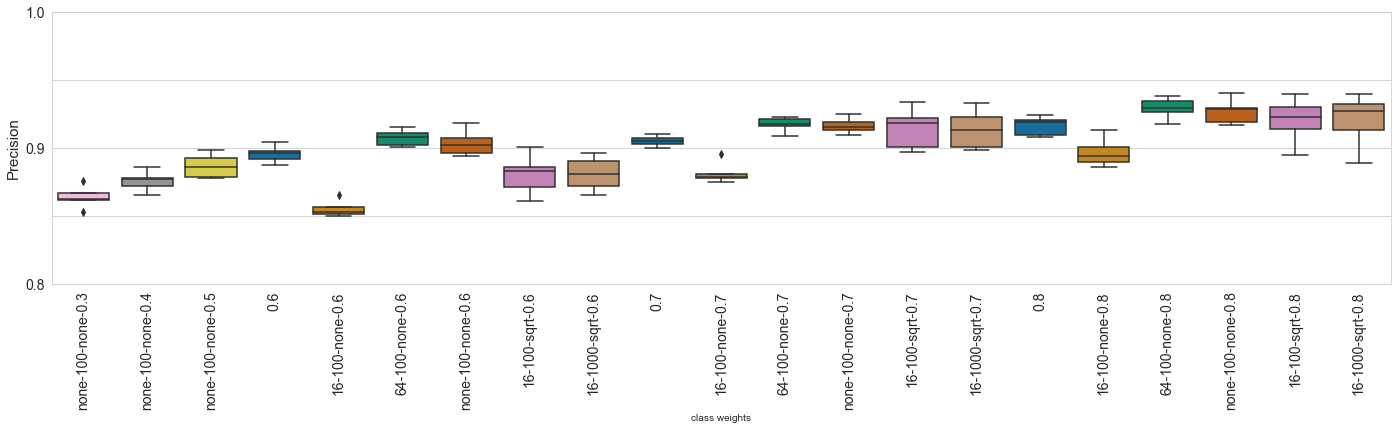

,Avg Precision,SEM
class weights,,
RandomForest/1-16-100-sqrt-0.6,0.880475,0.006767
RandomForest/16-64-100-none-0.6,0.907510,0.002761
RandomForest/17-64-100-none-0.7,0.917292,0.002436
RandomForest/18-64-100-none-0.8,0.929344,0.003610
RandomForest/2-16-100-sqrt-0.7,0.914623,0.006827
RandomForest/28-none-100-none-0.6,0.903704,0.004434
RandomForest/29-none-100-none-0.7,0.916491,0.002651
RandomForest/3-16-100-sqrt-0.8,0.920387,0.007554
RandomForest/30-none-100-none-0.8,0.926870,0.004172


In [73]:
metric = "Precision"
params = ["n_features", "n_estimators", "max_depth"]
y_ticks_major = [0.8, 1.01]
y_ticks_minor = True
other_columns = ["level", "model name", "confidence", "fold", "class weights"]
conf_levels = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-allmodels-updated-low-confs.svg")

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")

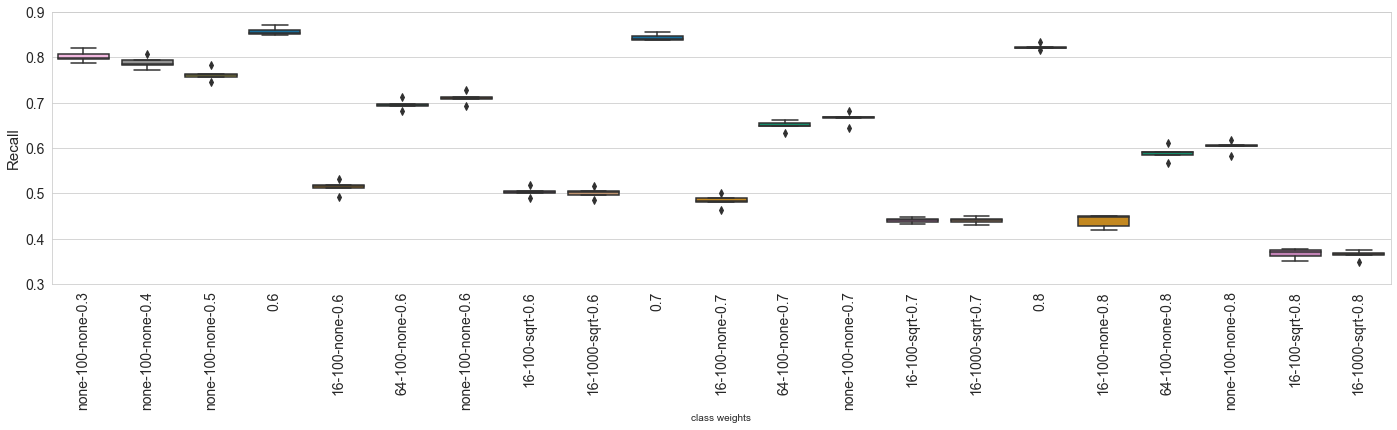

,Avg Recall,SEM
class weights,,
RandomForest/1-16-100-sqrt-0.6,0.503640,0.004694
RandomForest/16-64-100-none-0.6,0.695715,0.005011
RandomForest/17-64-100-none-0.7,0.649780,0.004720
RandomForest/18-64-100-none-0.8,0.588543,0.006901
RandomForest/2-16-100-sqrt-0.7,0.440261,0.002626
RandomForest/28-none-100-none-0.6,0.710548,0.005761
RandomForest/29-none-100-none-0.7,0.665533,0.006023
RandomForest/3-16-100-sqrt-0.8,0.367103,0.004878
RandomForest/30-none-100-none-0.8,0.603851,0.005791


In [74]:
metric = "Recall"
params = ["n_features", "n_estimators", "max_depth"]
y_ticks_major = [0.3, 0.95]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold", "class weights"]
conf_levels = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-allmodels-updated-low-confs.svg")

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")

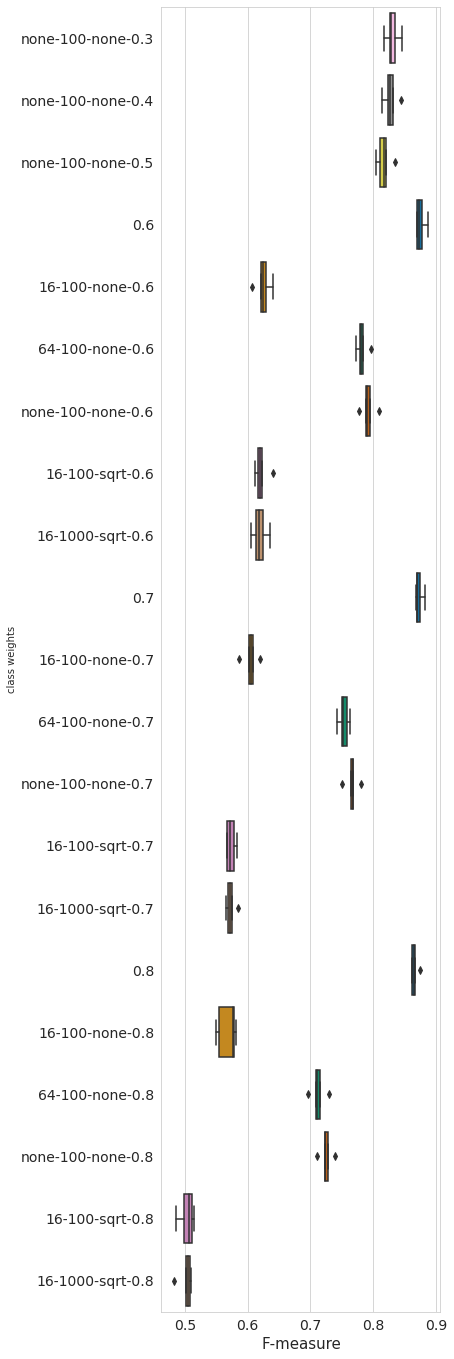

In [32]:
metric = "F-measure"
params = ["n_features", "n_estimators", "max_depth"]
y_lims = [0.52, 0.91]
y_ticks_major = [0.5, 1.0]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold", "class weights"]
conf_levels = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
palette = "colorblind"
# save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-allmodels-updated-low-confs-vertical.svg")
save_loc = None

data_slice = level7_weighted_folds[[metric] + params + other_columns]

selection1 = (data_slice["max_depth"].isin([16, "NB"])) & (data_slice["n_features"].isin(["sqrt", "NB"])) & (data_slice["n_estimators"].isin([100, 1000, "NB"]))  
selection2 = (data_slice["max_depth"].isin([16, "NB"])) & (data_slice["n_estimators"].isin([100, "NB"])) & (data_slice["n_features"].isin(["sqrt", "none", "NB"]))
selection3 = (data_slice["n_estimators"].isin([100, "NB"])) & (data_slice["n_features"].isin(["none", "NB"])) & (data_slice["max_depth"].isin([16, 64, "none", "NB"]))
selection4 = (data_slice["n_estimators"].isin([100])) & (data_slice["n_features"].isin(["none"])) & (data_slice["max_depth"].isin(["none"]))
data = data_slice[selection1 | selection2 | selection3 | selection4]

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 1)
    fig.set_size_inches(5, 24)
    
    # calculate mean metric for each fold by grouping by model
    # reset index to unstack all the levels from the multi-level index for easy plotting
    grouped_level7 = data.groupby(['model name', 'level', 'confidence', 'fold', "class weights"] + params)
    axis_data = grouped_level7.mean().reset_index()
    axis_data.sort_values(["confidence"] + params, ascending=True, inplace=True)
    
    # sort by confidence to plot in confidence groups
    all_models = axis_data["class weights"].unique()
    all_models_sorted = sorted(all_models, key=lambda x: x.split("-")[-1])
    
    # set proper colours (for first 3 boxes + 3 groups of 6 boxes)
    base_colors = sns.color_palette(palette, axis_data[params].drop_duplicates(inplace=False).shape[0] + 3)
    color_palette = base_colors[-3:] + base_colors[:-3] * 3
    g = sns.boxplot(x=metric, y="class weights", data=axis_data, ax=axes, palette=color_palette, order=all_models_sorted)
    
    # set custom y ticks
    g.xaxis.set_ticks(np.arange(y_ticks_major[0], y_ticks_major[1], 0.1))
    if y_ticks_minor:
        minor_locator = AutoMinorLocator(2)
        g.xaxis.set_minor_locator(minor_locator)
        g.tick_params(which='minor', length=4)
        g.grid(True, which='minor', axis='x')

    # set some font sizes
    g.xaxis.label.set_size(15)
    for tick in g.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in g.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        tick.label.set_rotation(0)
    
    # relabel x-axis tick for easier identification
    new_x_tick_labels = ["-".join(tick._text.split("/")[-1].split("-")[1:]) for tick in g.get_yticklabels()]
    g.set_yticklabels(new_x_tick_labels)
    
    if save_loc:
        fig.savefig(save_loc, dpi=300)

In [55]:
axis_data[["F-measure", "Precision", "Recall", "class weights"]].groupby("class weights").mean()

KeyError: "['Precision', 'Recall'] not in index"

In [34]:
axis_data[["F-measure", "class weights"]].groupby("class weights").sem()

,F-measure
class weights,
RandomForest/1-16-100-sqrt-0.6,0.004823
RandomForest/16-64-100-none-0.6,0.003754
RandomForest/17-64-100-none-0.7,0.003544
RandomForest/18-64-100-none-0.8,0.005542
RandomForest/2-16-100-sqrt-0.7,0.003028
RandomForest/28-none-100-none-0.6,0.005149
RandomForest/29-none-100-none-0.7,0.004832
RandomForest/3-16-100-sqrt-0.8,0.005300
RandomForest/30-none-100-none-0.8,0.004739


,F-measure,F-measure
class weights,,
RandomForest/1-16-100-sqrt-0.6,0.004823,0.621907
RandomForest/16-64-100-none-0.6,0.003754,0.782323
RandomForest/17-64-100-none-0.7,0.003544,0.753864
RandomForest/18-64-100-none-0.8,0.005542,0.711944
RandomForest/2-16-100-sqrt-0.7,0.003028,0.573106
RandomForest/28-none-100-none-0.6,0.005149,0.792389
RandomForest/29-none-100-none-0.7,0.004832,0.766562
RandomForest/3-16-100-sqrt-0.8,0.005300,0.503633
RandomForest/30-none-100-none-0.8,0.004739,0.725029
